# Time Series Analysis - POC

In [1]:
import pandas as pd
import os
import numpy as np
import time

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima # for determining ARIMA orders

import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

In [2]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from sklearn.metrics import r2_score, mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [3]:
import prophet
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [5]:
# dir(utils)

In [6]:
import utils
from utils import creating_time_series
from utils import load_single_timeseries
from utils import timeseries_eda
from utils import check_adfuller
from utils import model_evaluation 

In [7]:
input_path = f"{os.getcwd()}\\input_data\\"
ts_path = f"{os.getcwd()}\\ts_data\\"
data_file = "interview_dataset.xlsx"
figures_path = 'C:\\Users\\DKici\\Desktop\\Metrolinx\\figures\\'
data_path = input_path + data_file
data_path

'C:\\Users\\DKici\\Desktop\\Metrolinx\\notebook\\input_data\\interview_dataset.xlsx'

### Preprocess raw data and create sigle time series

Single Time Series for each rail corridor and station

data is loaded!


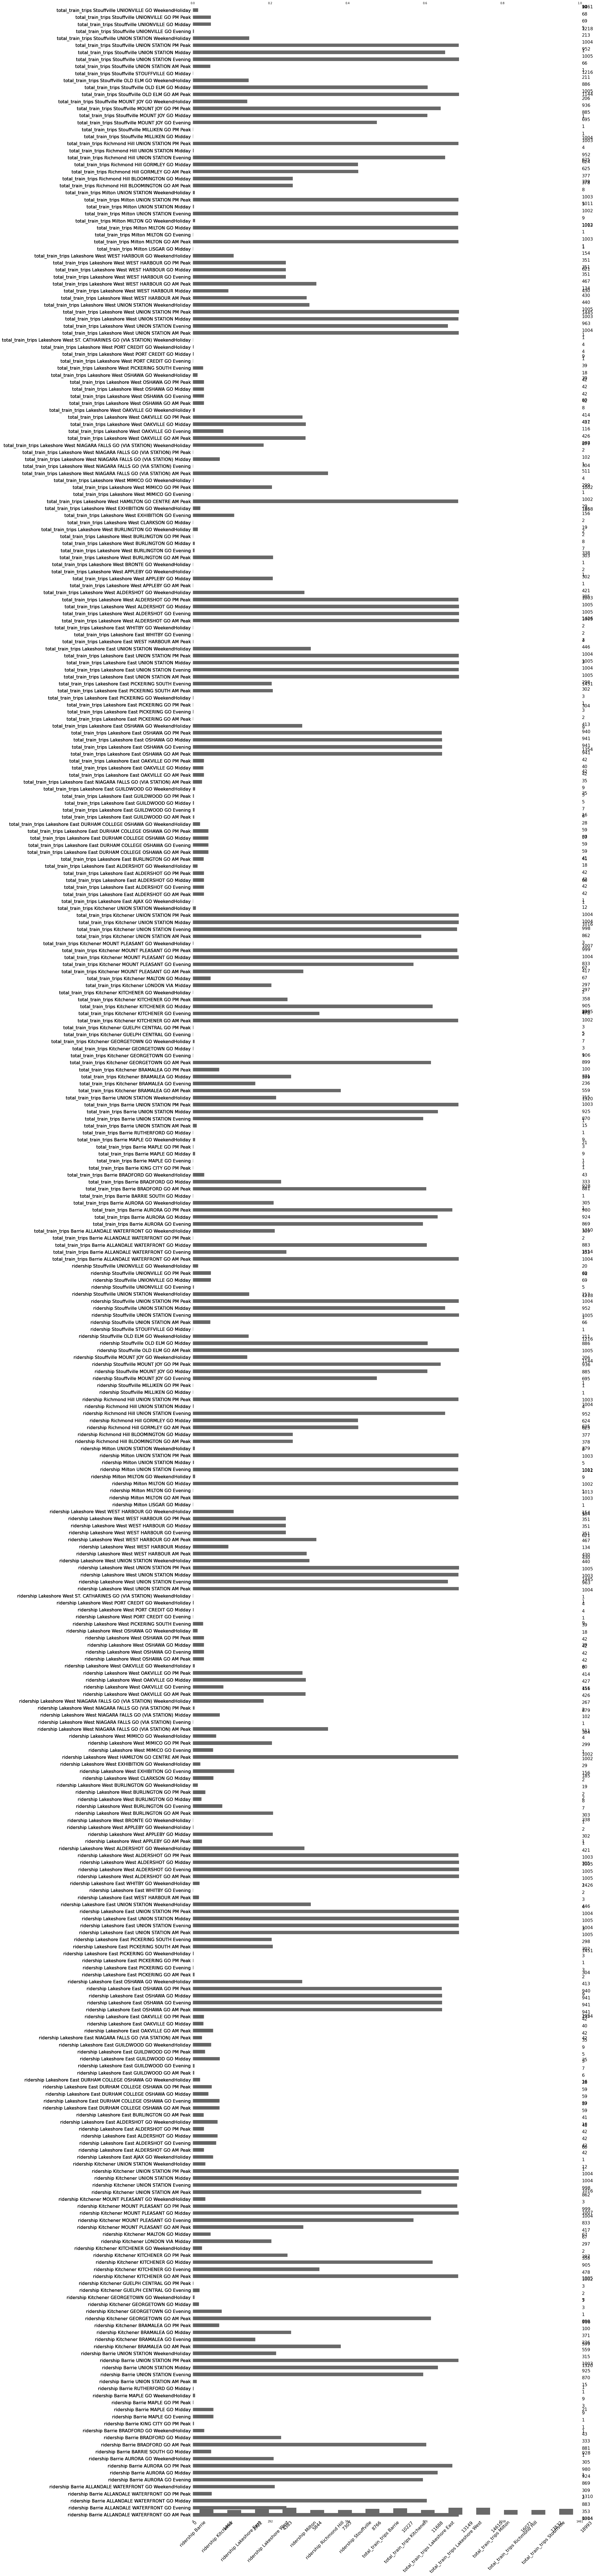

In [8]:
rc_data, rc_st_data, rc_st_tp_data = creating_time_series(data_path, ts_path)

In [9]:
rc_data

['Metrolinx_Barrie_Data',
 'Metrolinx_Lakeshore East_Data',
 'Metrolinx_Lakeshore West_Data',
 'Metrolinx_Kitchener_Data',
 'Metrolinx_Milton_Data',
 'Metrolinx_Richmond Hill_Data',
 'Metrolinx_Stouffville_Data']

In [10]:
rc_st_data

['Metrolinx_Barrie_ALLANDALE WATERFRONT GO_Data',
 'Metrolinx_Barrie_AURORA GO_Data',
 'Metrolinx_Barrie_UNION STATION_Data',
 'Metrolinx_Lakeshore East_UNION STATION_Data',
 'Metrolinx_Lakeshore East_OSHAWA GO_Data',
 'Metrolinx_Lakeshore West_UNION STATION_Data',
 'Metrolinx_Lakeshore West_ALDERSHOT GO_Data',
 'Metrolinx_Lakeshore West_HAMILTON GO CENTRE_Data',
 'Metrolinx_Kitchener_UNION STATION_Data',
 'Metrolinx_Kitchener_KITCHENER GO_Data',
 'Metrolinx_Kitchener_MOUNT PLEASANT GO_Data',
 'Metrolinx_Milton_UNION STATION_Data',
 'Metrolinx_Milton_MILTON GO_Data',
 'Metrolinx_Richmond Hill_UNION STATION_Data',
 'Metrolinx_Stouffville_UNION STATION_Data',
 'Metrolinx_Stouffville_OLD ELM GO_Data',
 'Metrolinx_Stouffville_MOUNT JOY GO_Data']

In [11]:
rc_st_tp_data

['Metrolinx_Barrie_ALLANDALE WATERFRONT GO_AM Peak_Data',
 'Metrolinx_Barrie_UNION STATION_PM Peak_Data',
 'Metrolinx_Lakeshore East_UNION STATION_AM Peak_Data',
 'Metrolinx_Lakeshore East_UNION STATION_Midday_Data',
 'Metrolinx_Lakeshore East_UNION STATION_Evening_Data',
 'Metrolinx_Lakeshore East_UNION STATION_PM Peak_Data',
 'Metrolinx_Lakeshore West_UNION STATION_AM Peak_Data',
 'Metrolinx_Lakeshore West_UNION STATION_Midday_Data',
 'Metrolinx_Lakeshore West_UNION STATION_PM Peak_Data',
 'Metrolinx_Lakeshore West_ALDERSHOT GO_AM Peak_Data',
 'Metrolinx_Lakeshore West_ALDERSHOT GO_Midday_Data',
 'Metrolinx_Lakeshore West_ALDERSHOT GO_Evening_Data',
 'Metrolinx_Lakeshore West_ALDERSHOT GO_PM Peak_Data',
 'Metrolinx_Lakeshore West_HAMILTON GO CENTRE_AM Peak_Data',
 'Metrolinx_Kitchener_UNION STATION_Midday_Data',
 'Metrolinx_Kitchener_UNION STATION_PM Peak_Data',
 'Metrolinx_Kitchener_KITCHENER GO_AM Peak_Data',
 'Metrolinx_Kitchener_MOUNT PLEASANT GO_Midday_Data',
 'Metrolinx_Milton_

### Load Single Time Series

I randomly selected Metrolinx_Lakeshore East_UNION STATION for the analysis.

In [12]:
ts = "Metrolinx_Lakeshore East_UNION STATION_Data.csv"
st = "Metrolinx_Lakeshore East_UNION STATION"
ts_data_path = ts_path + ts
ts_data_path

'C:\\Users\\DKici\\Desktop\\Metrolinx\\notebook\\ts_data\\Metrolinx_Lakeshore East_UNION STATION_Data.csv'

I splitted the data in different datasets by load_single_timeseries function.

-- The first is data_all - the original time series with ridership numbers, which I will make prediction for feature and number of trips

-- The second one is data_regressors that includes the trip numbers. I will use this as the regressor in the prophet model since the number of trips mighr effect the totoal nmumber of riders.

-- The third one is data, which inclused only number of trips. 

For Prophet, wee need three types of dataset. But for classical models, I will just use one of them.

In this time series there three features as date, number of riders, and number of trips.

There are 1451 rows in total. However, based on the start and end dates, there must be 1461 time stamps in a daily dataset.

Therefore, I implemented the following preprocessing on this time series:

1- I filled the missing time stamps with 0 by assuming there was no trip and/or no riders in these days.

2 - I also added one more day to the time series to make it easier the use of lists. The data in this additional row is never used.

3 - I changed data types of ridership and trips columns from obejct to integer numbers.

In [13]:
data_all, data, data_regressors = load_single_timeseries(ts_data_path)

time series loaded!
Data All: 
              ridership  trips
date                        
2019-01-02         26      1
2019-01-03       3397     14
2019-01-04       3615     14
2019-01-05       3130     14
2019-01-06        226      1
Data: 
              ridership
date                 
2019-01-02         26
2019-01-03       3397
2019-01-04       3615
2019-01-05       3130
2019-01-06        226
Data Regressors: 
              trips
date             
2019-01-02      1
2019-01-03     14
2019-01-04     14
2019-01-05     14
2019-01-06      1


In [14]:
data_all.head()

,ridership,trips
date,,
2019-01-02,26,1
2019-01-03,3397,14
2019-01-04,3615,14
2019-01-05,3130,14
2019-01-06,226,1


### Exploratory Time Series Analysis

#### Visualization
In EDA, first, I visualized the time series to have an understanding of the time series. 

#### Trend and Seasonaliy
In time series analysis, I checked two important features: Trend and seasonality.

Time series is suppoased to be stationary that means it must be no trends and seasonality, in another words it must be not a function of time. If time series is stationary, it implies there is no predictable pattern in the long term.

I use Augmented-Dickey Fuller Test to for trend analysis.

As a result of this test if the p-value is bigger than 0.05, it means that time-series data is non-stationary.

#### Decomposition
In Exploratory data analysis, I also use decomposition of the time series. It shows us trens, seasonality, and residuals.

There are two decomposition methods: Additive and multiplicative.

Additive  means the time series is the addition of base values, trend, seasonality, and resiudals while the multpilicative 
is the multiplication of base values, trend, seasonality, and resiudals. 

I only use only additive model here since this time series has 0 values. Multiplicative model does not accept any non-zero or missing values. 

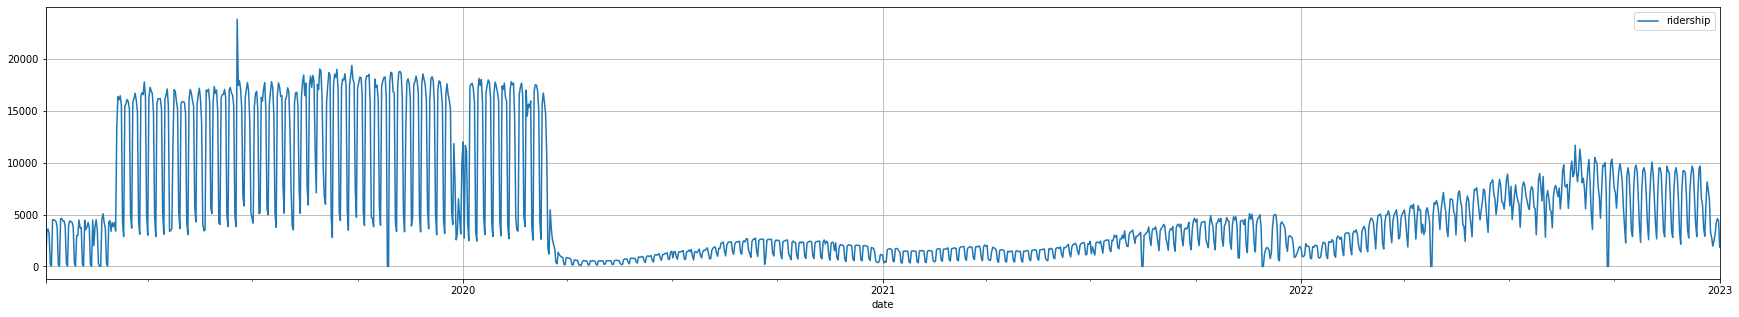

C:\Users\DKici\Desktop\Metrolinx\notebook\utils.py:248: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  data_decompose_add.plot().show()


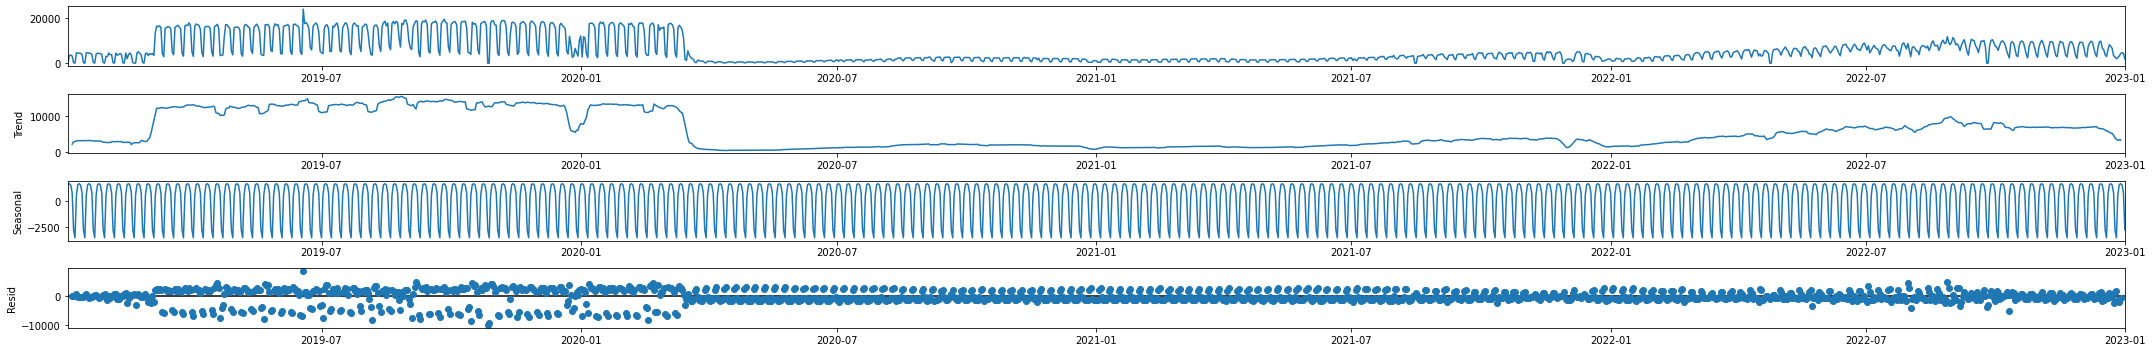

In [15]:
timeseries_eda(data)

In [16]:
check_adfuller(data)

Test statistic:  -1.9277800750981222
p-value:  0.31910743113489337
Critical Values: {'1%': -3.4349056408696814, '5%': -2.863552005375758, '10%': -2.5678411776130114}
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


ACF and PACF plots also help to observe seasonality. 

<IPython.core.display.Javascript object>

C:\Users\DKici\Anaconda3\envs\Dart_env_37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


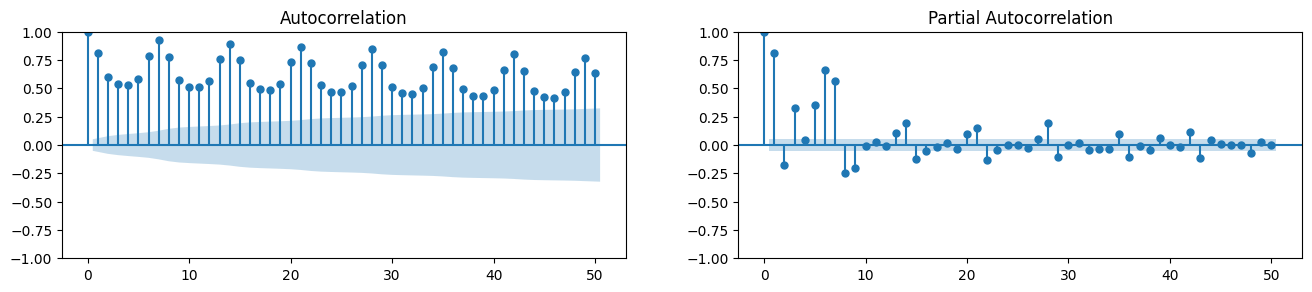

In [17]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data, lags=50, ax=axes[0]);
plot_pacf(data, lags=50, ax=axes[1]);

To make the time series stationary, I use differencing method.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

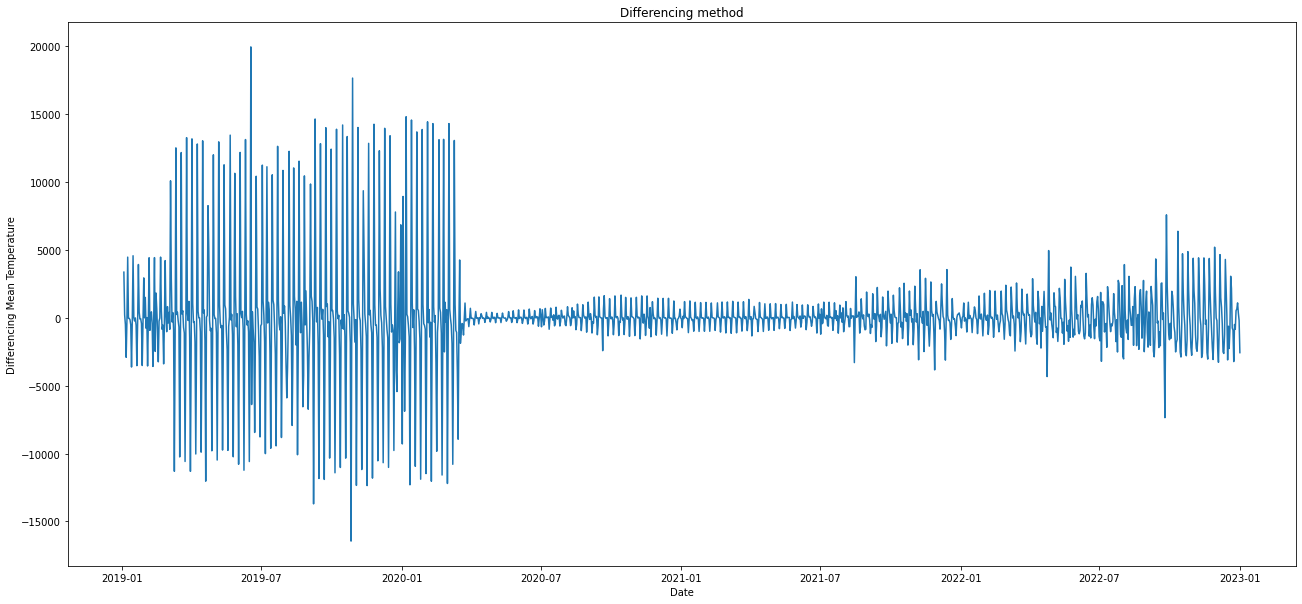

In [18]:
data_diff = data - data.shift()
plt.figure(figsize=(22,10))
plt.plot(data_diff)
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

In [19]:
data_diff.dropna(inplace=True) 
check_adfuller(data_diff)

Test statistic:  -9.139387084132176
p-value:  2.876773202343316e-15
Critical Values: {'1%': -3.4349056408696814, '5%': -2.863552005375758, '10%': -2.5678411776130114}
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Now, the time series has no unit root and it is stationary.

<IPython.core.display.Javascript object>

C:\Users\DKici\Anaconda3\envs\Dart_env_37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


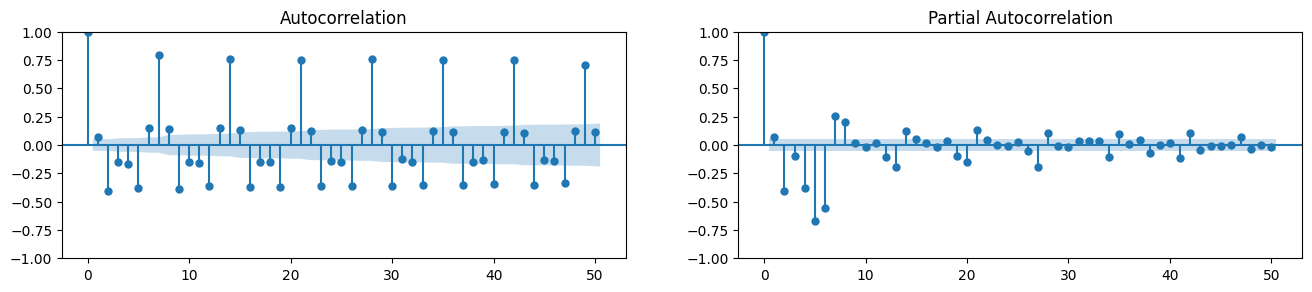

In [20]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data_diff, lags=50, ax=axes[0]);
plot_pacf(data_diff, lags=50, ax=axes[1]);

### Train-Test Split

I take 3 years as training data and 1 year for testing

In [21]:
train = data.iloc[:-365,:] # 3 years (75%)
test = data.iloc[-365:,:] # 1 year (25%)
len(train),len(test)

(1096, 365)

### MODEL 1 - ARIMA

I use auto_arima to identify parameters

In [22]:
arima_model = auto_arima(train, start_p=0, start_q=0,
                      max_p=2, max_q=2, m=6,
                      d=None, trace=True,
                      error_action='ignore',   # we don't want to know if an order does not work
                      suppress_warnings=True,  # we don't want convergence warnings
                      stepwise=True)           # set to stepwise

arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[6] intercept   : AIC=21072.210, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=21191.334, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=21174.707, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=20836.335, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=21189.334, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=21177.526, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=20838.273, Time=1.15 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=20962.040, Time=0.55 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=21174.544, Time=0.24 sec
 ARIMA(0,1,1)(1,0,2)[6] intercept   : AIC=20733.679, Time=2.34 sec
 ARIMA(0,1,1)(2,0,2)[6] intercept   : AIC=20652.435, Time=1.52 sec
 ARIMA(0,1,1)(2,0,1)[6] intercept   : AIC=20598.169, Time=1.79 sec
 ARIMA(0,1,1)(2,0,0)[6] intercept   : AIC=20737.998, Time=1.51 sec
 ARIMA(0,1,0)(2,0,1)[6] intercept   : AIC=20959.176, Time=0.56 sec
 ARIMA(1,1,1)(2,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1096
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 6)   Log Likelihood              -10106.098
Date:                           Tue, 02 May 2023   AIC                          20230.195
Time:                                   21:07:51   BIC                          20275.182
Sample:                                        0   HQIC                         20247.218
                                          - 1096                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2323      0.042     -5.485      0.000      -0.315      -0.149
ar.L2         -0.4170      0.023    -17.929      0.000      -0.463      -0.371
ma.L1         -0.3890      0.042     -9.260      0.000      -0.471      -0.307
ma.L2         -0.2499      0.037     -6.720      0.000      -0.323      -0.177
ar.S.L6        1.2380      0.005    266.163      0.000       1.229       1.247
ar.S.L12      -0.9735      0.005   -203.081      0.000      -0.983      -0.964
ma.S.L6       -1.1470      0.016    -72.724      0.000      -1.178      -1.116
ma.S.L12       0.7485      0.016     46.299      0.000       0.717       0.780
sigma2      5.028e+06   5.73e-09   8.77e+14      0.000    5.03e+06    5.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):               782.93
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.26e+31. Standard errors may be unstable.
"""

<IPython.core.display.Javascript object>

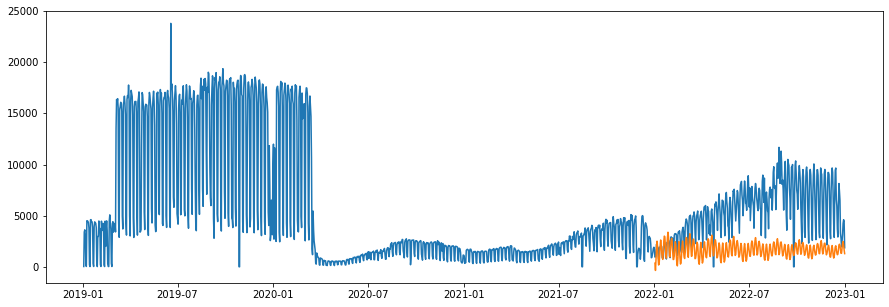

In [23]:
# Forecast
prediction = arima_model.predict(n_periods=len(test))
# prediction
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data.ridership)
ax.plot(prediction_series)

In [24]:
r2_score(test['ridership'], prediction_series)

-2.063682611887842

In [25]:
mse, rmse, r2 = model_evaluation(test['ridership'], prediction_series, "ARIMA", st)


 Metrolinx_Lakeshore East_UNION STATION ARIMA MSE Error: 20869683.08
 Metrolinx_Lakeshore East_UNION STATION ARIMA  RMSE Error: 4568.334825 
 Metrolinx_Lakeshore East_UNION STATION ARIMA  R square: -2.063682612


As the evaluation metrics and plot above suggested, the prediction results are not good. R-quare value is not as expected. Then we can say that ARIMA model is not useful in this time series.

# Model 2 - LSTM

LSTM requires a specific format of scaled data. I use MinMax scaler here. 

This scaler transfrom data as;

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

In [26]:
scaler = MinMaxScaler()
scaler.fit(train.values.reshape(-1,1))

scaled_train = scaler.transform(train.values.reshape(-1,1))
scaled_test = scaler.transform(test.values.reshape(-1,1))

In [27]:
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=8)
print('Samples: %d' % len(generator))

# What does the first batch look like?
# X,y = generator[0]

# print(f'Given the Array: \n{X.flatten()}')
# print(f'Predict this y: \n {y}')

Samples: 137


In [28]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
import time

# Start timer
start_time = time.perf_counter()

# fit model
model.fit_generator(generator,epochs=100)

# End timer
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Epoch 1/100


C:\Users\DKici\Anaconda3\envs\Dart_env_37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


137/137 [==============================] - 1s 2ms/step - loss: 0.0386 - accuracy: 0.0064
Epoch 2/100
137/137 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.0064
Epoch 3/100
137/137 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.0064
Epoch 4/100
137/137 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.0064
Epoch 5/100
137/137 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.0064
Epoch 6/100
137/137 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.0064
Epoch 7/100
137/137 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.0064
Epoch 8/100
137/137 [==============================] - 0s 2ms/step - loss: 0.0087 - accuracy: 0.0055
Epoch 9/100
137/137 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.0064
Epoch 10/100
137/137 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.0064
E

<IPython.core.display.Javascript object>

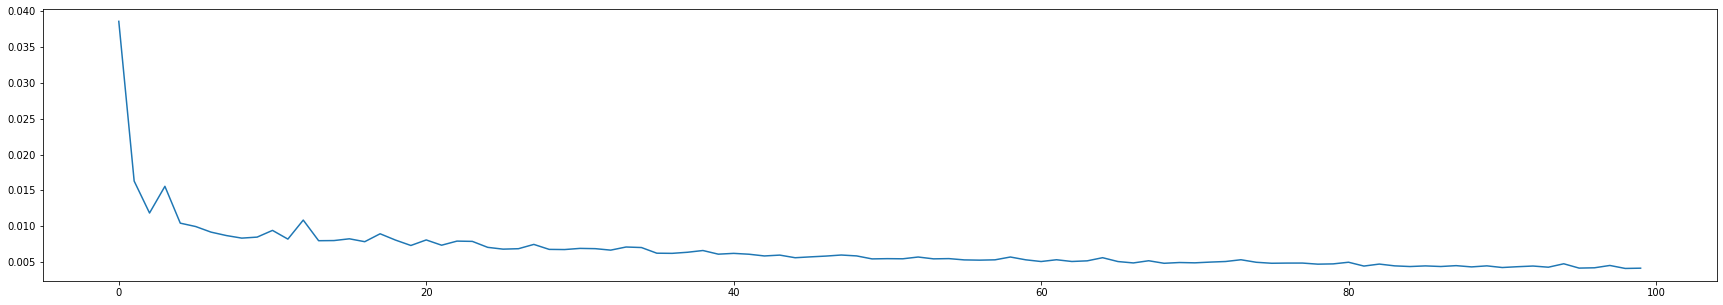

In [30]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [31]:
first_eval_batch = scaled_train[-7:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [32]:
for i in range(len(test)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred) 
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

<AxesSubplot:xlabel='date'>

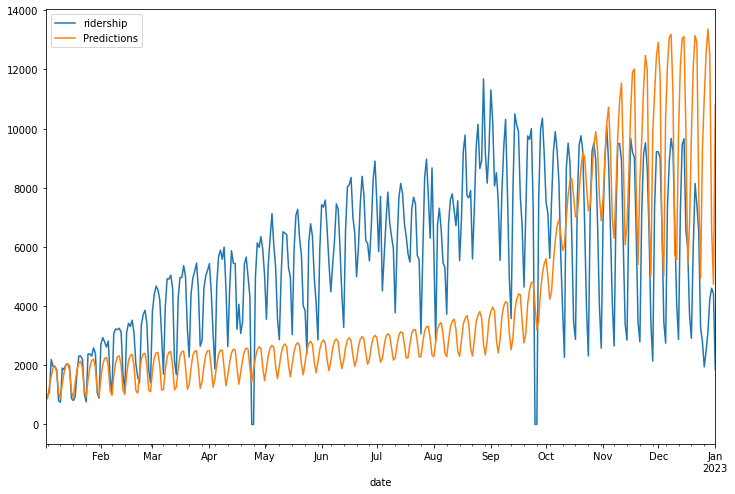

In [33]:
# Inverse Transformations and Compare
true_predictions = scaler.inverse_transform(test_predictions)
test = pd.DataFrame(test)
test['Predictions'] = true_predictions
test.plot(figsize=(12,8))

In [34]:
mse, rmse, r2 = model_evaluation(test['ridership'], test['Predictions'], "LSTM", st)


 Metrolinx_Lakeshore East_UNION STATION LSTM MSE Error: 12271474.62
 Metrolinx_Lakeshore East_UNION STATION LSTM  RMSE Error: 3503.066459 
 Metrolinx_Lakeshore East_UNION STATION LSTM  R square: -0.8014601981


# Model 3 - Prophet

In [35]:
df = data.merge(data_regressors, on ='date')  
df = df.reset_index()
df = df.rename(columns = {'ridership':'y', 'date':'ds'})
df.head()

,ds,y,trips
0,2019-01-02,26,1
1,2019-01-03,3397,14
2,2019-01-04,3615,14
3,2019-01-05,3130,14
4,2019-01-06,226,1


In [36]:
holidays = pd.read_csv(f'{input_path}/holidays.csv')
holidays.columns= holidays.columns.str.lower()
holidays = holidays.iloc[:,:-2]
# print(holidays)

In [37]:
##### Model Development with Cross-Validation

# Start timer
start_time = time.perf_counter()

################ Cross-Validation ################
print(" \n  ########## Cross validation ######### ")

m = Prophet(holidays=holidays
            ,holidays_prior_scale=0.25
            ,changepoint_prior_scale=0.01
            ,seasonality_mode='additive'
            ,weekly_seasonality=True)

m.add_regressor('trips' , prior_scale=0.5, mode='additive')
m.fit(df)
m_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')



# End timer
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

 
  ########## Cross validation ######### 


21:08:36 - cmdstanpy - INFO - Chain [1] start processing
21:08:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

21:08:38 - cmdstanpy - INFO - Chain [1] start processing
21:08:38 - cmdstanpy - INFO - Chain [1] done processing
21:08:39 - cmdstanpy - INFO - Chain [1] start processing
21:08:39 - cmdstanpy - INFO - Chain [1] done processing
21:08:40 - cmdstanpy - INFO - Chain [1] start processing
21:08:41 - cmdstanpy - INFO - Chain [1] done processing


Elapsed time:  6.558103399999993


C:\Users\DKici\Anaconda3\envs\Dart_env_37\lib\site-packages\prophet\plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\DKici\Anaconda3\envs\Dart_env_37\lib\site-packages\prophet\plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\DKici\Anaconda3\envs\Dart_env_37\lib\site-packages\prophet\plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\DKici\Anaco

 
 Ridership- CV-metrics mean 

horizon     201 days 00:00:00
mse            37625790.99809
rmse              6048.105489
mae               5156.497156
mdape                1.220829
smape                1.334697
coverage              0.26019
dtype: object
             ds  trips
0    2019-01-02      1
1    2019-01-03     14
2    2019-01-04     14
3    2019-01-05     14
4    2019-01-06      1
...         ...    ...
1456 2022-12-28     37
1457 2022-12-29     41
1458 2022-12-30     41
1459 2022-12-31     41
1460 2023-01-01     35

[1461 rows x 2 columns]

 Metrolinx_Lakeshore East_UNION STATION Prophet MSE Error:   3449942.1
 Metrolinx_Lakeshore East_UNION STATION Prophet  RMSE Error: 1857.401976 
 Metrolinx_Lakeshore East_UNION STATION Prophet  R square: 0.4935463283


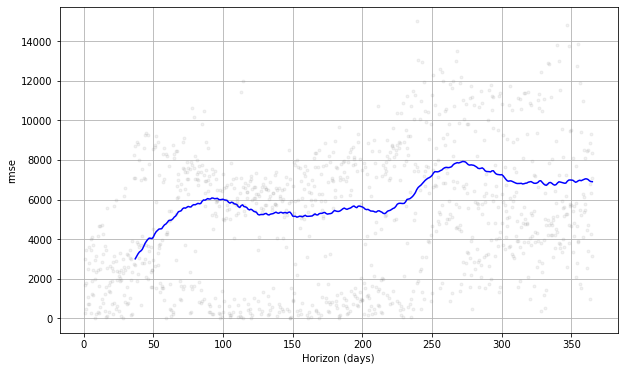

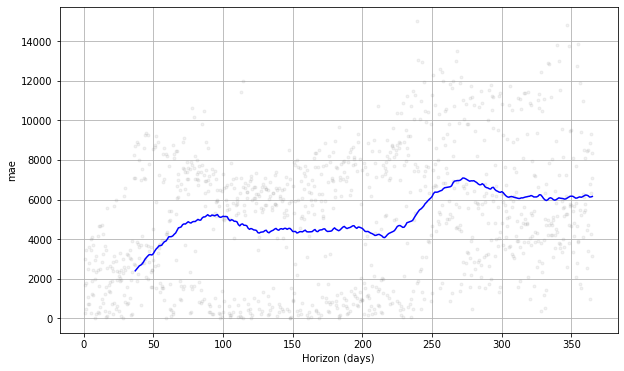

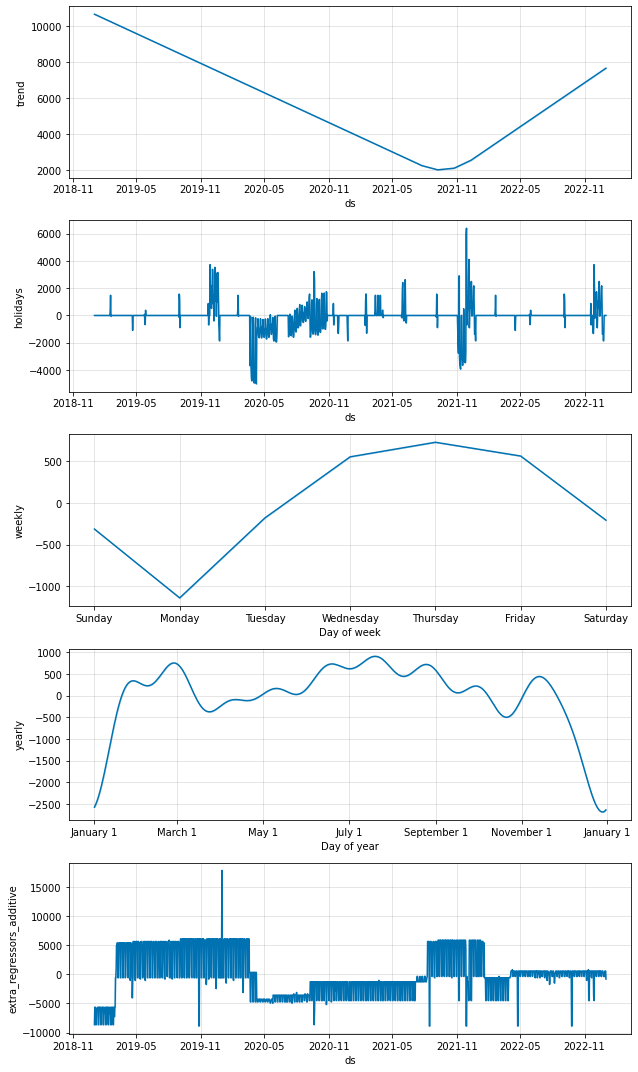

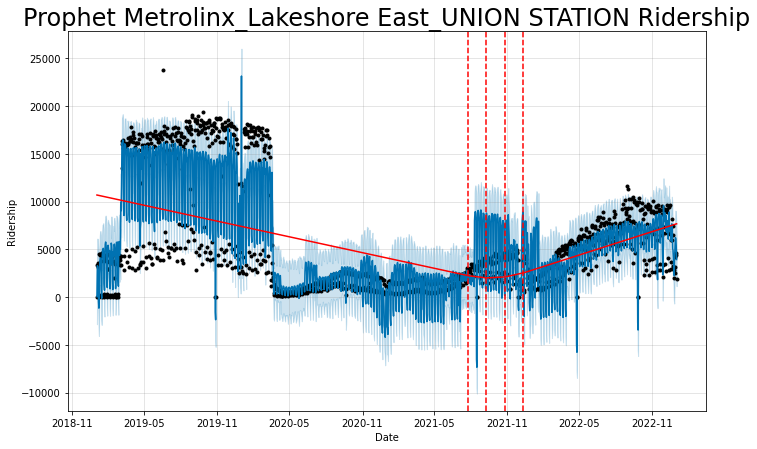

In [38]:
metrics = performance_metrics(m_cv)
# print(f" \n Ridership - CV-metrics \n")
# print("metrics are:",metrics)

fig = plot_cross_validation_metric(m_cv, metric='rmse')
fig = plot_cross_validation_metric(df_cv=m_cv, metric='mae', rolling_window=0.1)
print(f" \n Ridership- CV-metrics mean \n")
print(metrics.mean())

data_regressors = data_regressors.reset_index()
data_futures = data_regressors.copy()
data_futures = data_futures.rename(columns={'date':'ds'})
print(data_futures)

forecast = m.predict(data_futures)
forecast.to_csv(f"C:\\Users\\DKici\\Desktop\\Metrolinx\\forecasts\\Prophet_{st}_Ridership_forecast.csv")
f = m.plot_components(forecast).savefig(f'{figures_path}/Prophet_{st}_Components_Ridership.jpeg');

fig = m.plot(forecast, xlabel='Date', ylabel='Ridership')
a = add_changepoints_to_plot(fig.gca(), m, forecast)
ax = fig.gca()
ax.set_title(f"Prophet {st} Ridership", size=24)

fig.savefig(f'{figures_path}/Prophet_{st}_change_points_Ridership.jpeg');

mse, rmse, r2 = model_evaluation(test['ridership'], forecast.iloc[-365:,-1], "Prophet", st)
# print(f" \n Ridership- regressor coefficients {regressor_coefficients}")
# print(regressor_coefficients(m))

########### Save the model ###########
#In Python, models should not be saved with pickle; 
#the Stan backend attached to the model object will not pickle well, 
#and will produce issues under certain versions of Python. 
#Instead, you should use the built-in serialization functions to serialize the model to json:

# from prophet.serialize import model_to_json, model_from_json

# with open(f'{path}/models/serialized_model_Ridership.json', 'w') as fout:
#     fout.write(model_to_json(m))  # Save model

